In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'food41:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1864%2F33884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240213%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240213T133258Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d66538619d56021edcf77b27219e15d7139f356e4d321bdc911cafab5644b0f1a26ad72cb7a2e9c8045c35048e7c50bd5e3f7ebc86d75432dcc27659ca671a323903a90f43073c5ca1ef6b71da70a789ffc29c078f1c6369f20a8788d3499a52bc3d699ef1603f5ec72c80cb3219f53d88960c05944a6ad16bd7b3860ba26e6c9c093ec265eecae028210c623b8794dc683a858cd4efe235d045e3f14a851782966e5542b1c3e0bd24ffe8a630fa34dc6e4ccbcefb3ae10ff99bfee2fcb738b65b8d0cd35aa2a36bb25e3fd08363e3b12e9c252caf3d326367d5593c3f248b8eeab7975c4aea5bbfc558b82f62f5f17169d3d497e98fc7de949434cb647937a'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5693808106 bytes downloaded
Downloaded and uncompressed: food41
Data source import complete.


# Задача

***

## Модель классификации еды.  

Для обучения используется данные из выборки Food101. Для создания модели используется TensorFlow

# Подключаем модули.

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
# Ограничение на использования GPU.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
image_directory = Path('../input/food41/images')

# Создаем файл DataFrame

In [ ]:
filepaths = list(image_directory.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_dataframe = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [ ]:
image_dataframe

,Filepath,Label
0,../input/food41/images/fried_calamari/1413010.jpg,fried_calamari
1,../input/food41/images/macaroni_and_cheese/312...,macaroni_and_cheese
2,../input/food41/images/takoyaki/1836141.jpg,takoyaki
3,../input/food41/images/spaghetti_carbonara/227...,spaghetti_carbonara
4,../input/food41/images/pad_thai/2263335.jpg,pad_thai
...,...,...
10095,../input/food41/images/steak/1836332.jpg,steak
10096,../input/food41/images/cheese_plate/136339.jpg,cheese_plate
10097,../input/food41/images/onion_rings/3364870.jpg,onion_rings
10098,../input/food41/images/clam_chowder/3523678.jpg,clam_chowder


In [ ]:
image_dataframe['Label'].value_counts()

fried_calamari          100
hamburger               100
greek_salad             100
baby_back_ribs          100
pork_chop               100
                       ... 
pho                     100
deviled_eggs            100
strawberry_shortcake    100
dumplings               100
waffles                 100
Name: Label, Length: 101, dtype: int64

In [ ]:
image_dataframe['Label'].value_counts()

apple_pie        100
miso_soup        100
peking_duck      100
panna_cotta      100
pancakes         100
                ... 
donuts           100
deviled_eggs     100
cup_cakes        100
croque_madame    100
waffles          100
Name: Label, Length: 101, dtype: int64

# Делим на тестовую и тренировочную выборку.

In [ ]:
training_dataframe, testing_dataframe = train_test_split(image_dataframe, train_size=0.7, shuffle=True, random_state=1)

# Создаем генераторы

In [ ]:
train_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
training_images = train_generator.flow_from_dataframe(
    dataframe=training_dataframe,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

validation_images = train_generator.flow_from_dataframe(
    dataframe=training_dataframe,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

testing_images = test_generator.flow_from_dataframe(
    dataframe=testing_dataframe,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


# Создаем модель

Используем для создания собственной моделиб MobileNetV2 в качестве основы.

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    alpha=1.0
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


Используем функциональное Tensorflow API

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

# Тренировка

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    training_images,
    validation_data=validation_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
177/177 [==============================] - 359s 2s/step - loss: 3.8647 - accuracy: 0.1421 - val_loss: 3.0039 - val_accuracy: 0.2723
Epoch 2/100
177/177 [==============================] - 307s 2s/step - loss: 2.4254 - accuracy: 0.3946 - val_loss: 2.5536 - val_accuracy: 0.3649
Epoch 3/100
177/177 [==============================] - 308s 2s/step - loss: 1.8905 - accuracy: 0.5032 - val_loss: 2.4921 - val_accuracy: 0.3883
Epoch 4/100
177/177 [==============================] - 300s 2s/step - loss: 1.5001 - accuracy: 0.6047 - val_loss: 2.4346 - val_accuracy: 0.3975
Epoch 5/100
177/177 [==============================] - 283s 2s/step - loss: 1.1899 - accuracy: 0.6782 - val_loss: 2.4652 - val_accuracy: 0.4003
Epoch 6/100
177/177 [==============================] - 291s 2s/step - loss: 0.9421 - accuracy: 0.7534 - val_loss: 2.5582 - val_accuracy: 0.4144
Epoch 7/100
177/177 [==============================] - 295s 2s/step - loss: 0.7247 - accuracy: 0.8101 - val_loss: 2.6134 - val_accuracy:

# Результаты

In [ ]:
results = model.evaluate(testing_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 41.35%


In [ ]:
predictions = np.argmax(model.predict(testing_images), axis=1)

cm = confusion_matrix(testing_images.labels, predictions)
clr = classification_report(testing_images.labels, predictions, target_names=testing_images.class_indices, zero_division=0)

95/95 [==============================] - 122s 1s/step


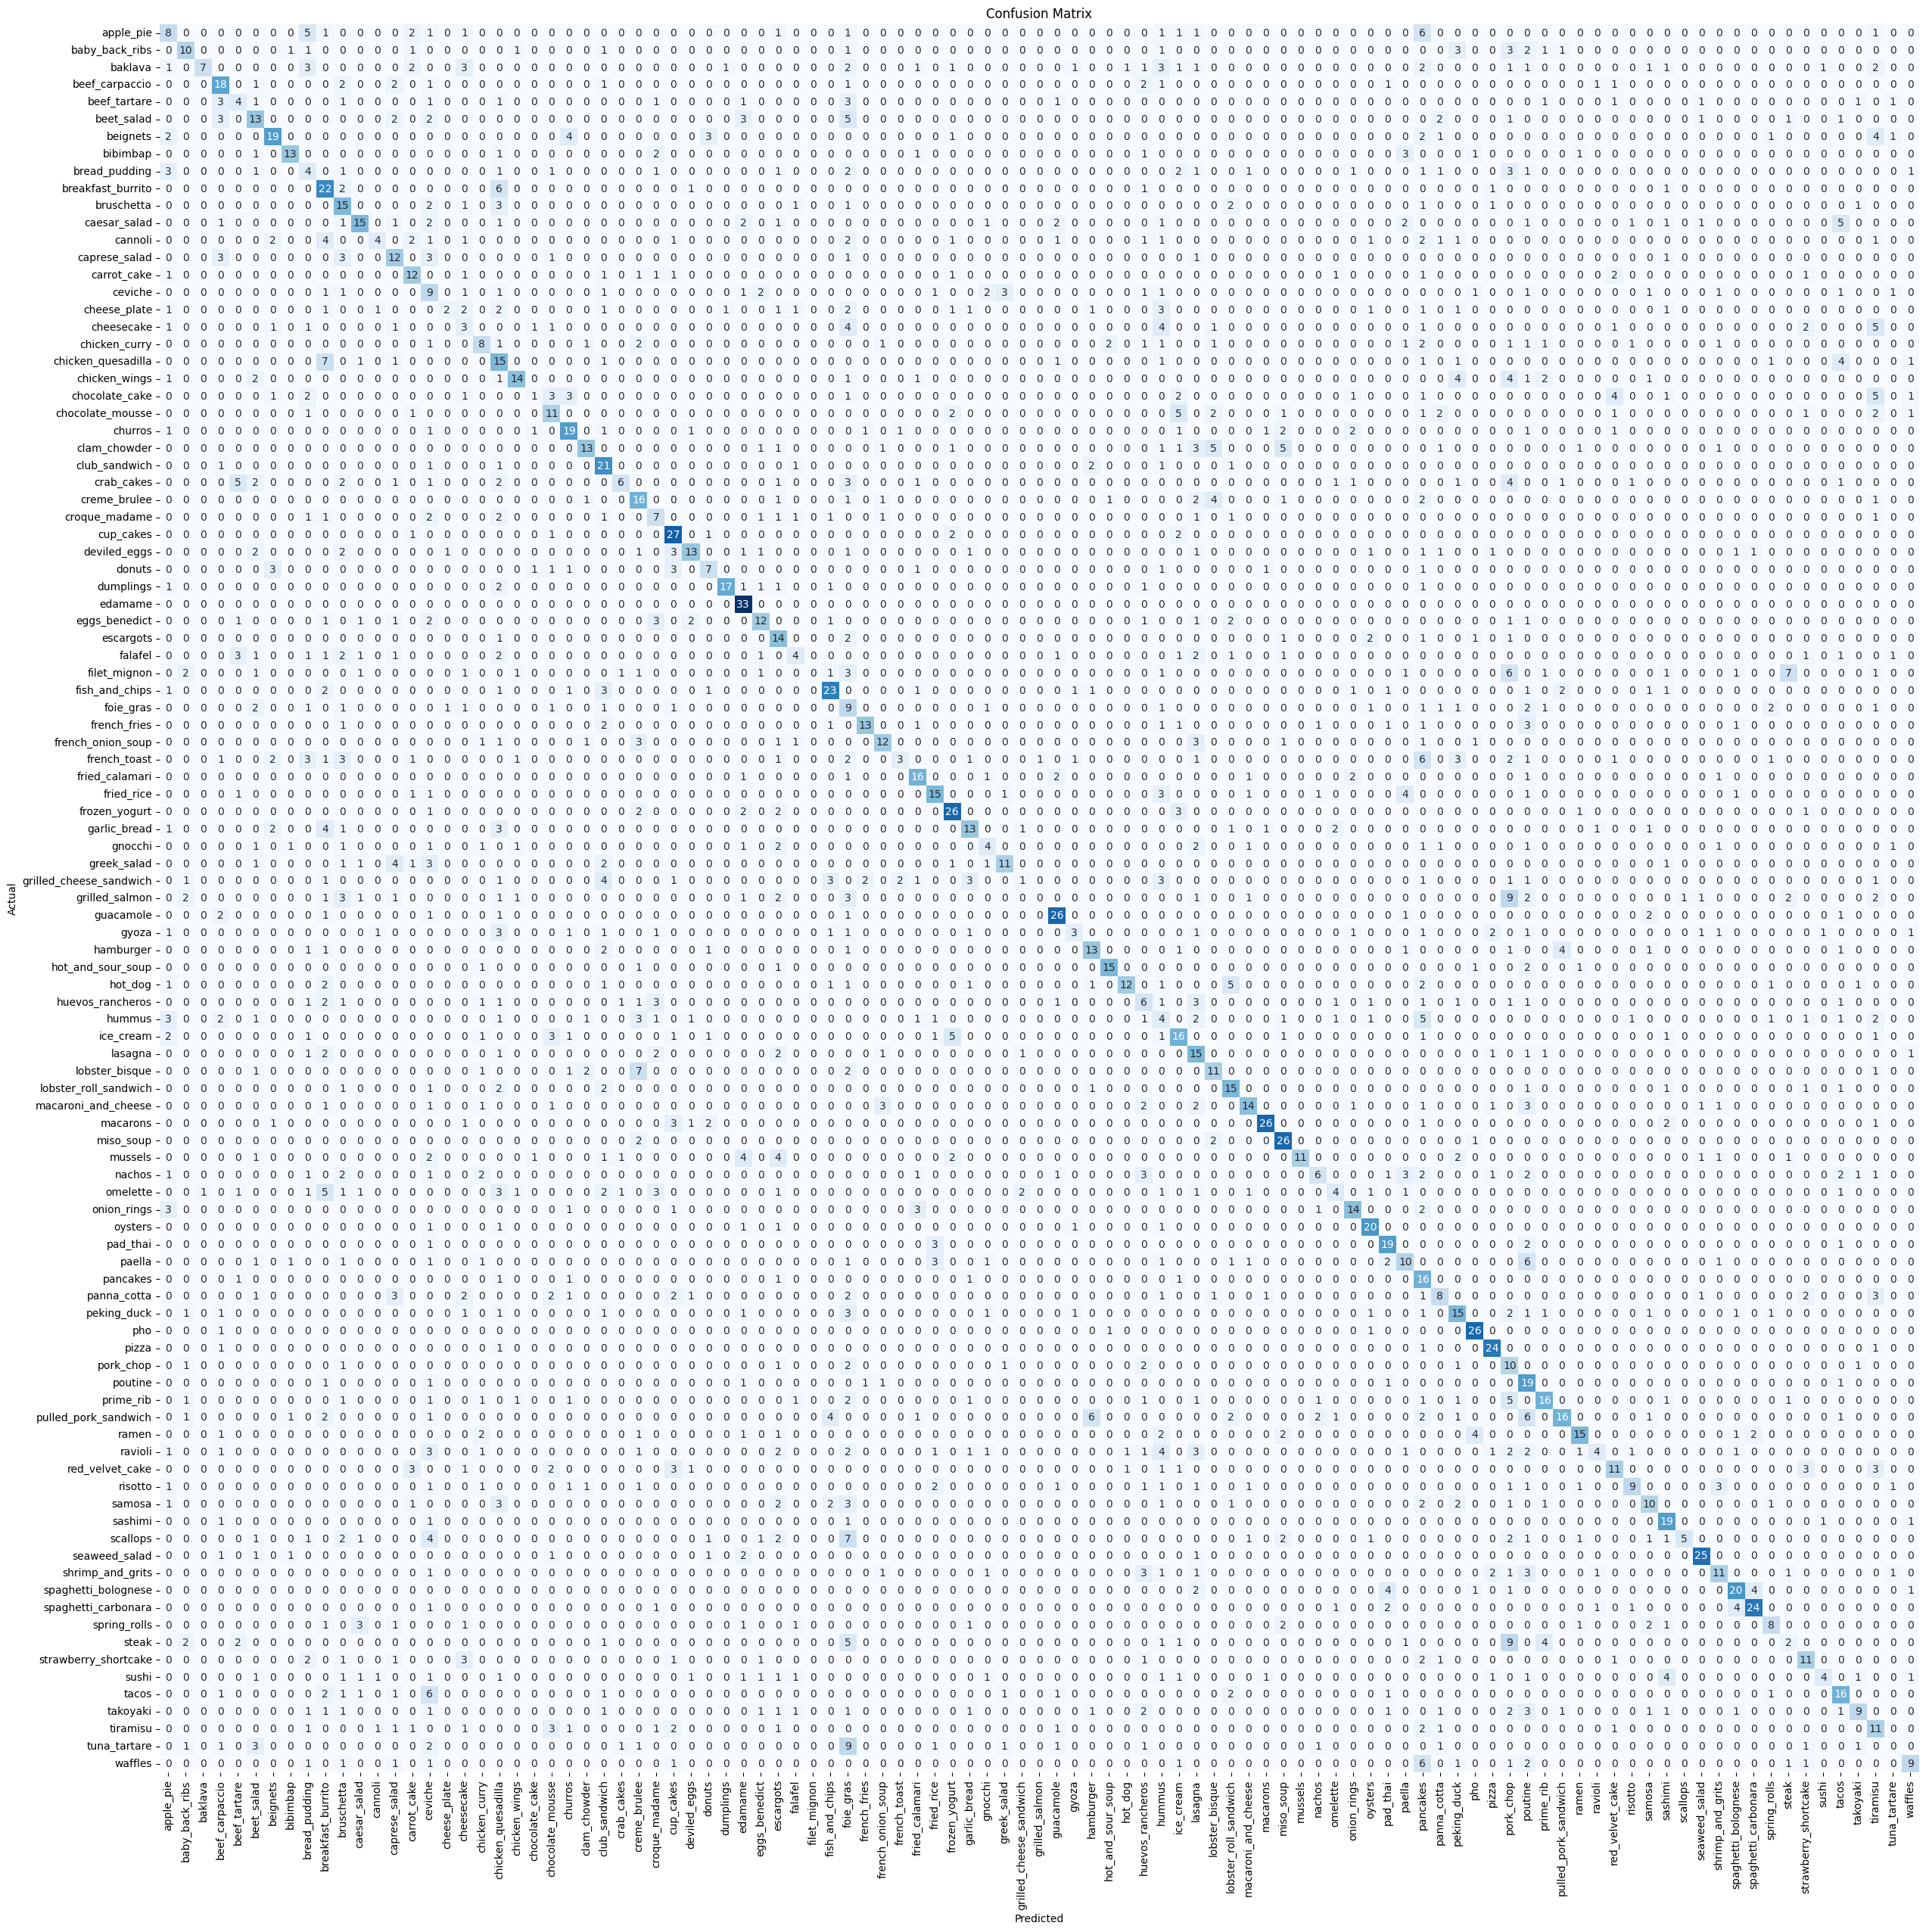

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=testing_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=testing_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.22      0.27      0.24        30
         baby_back_ribs       0.45      0.37      0.41        27
                baklava       0.88      0.18      0.30        38
         beef_carpaccio       0.42      0.56      0.48        32
           beef_tartare       0.22      0.18      0.20        22
             beet_salad       0.33      0.38      0.35        34
               beignets       0.61      0.50      0.55        38
               bibimbap       0.72      0.54      0.62        24
          bread_pudding       0.11      0.15      0.13        27
      breakfast_burrito       0.32      0.65      0.43        34
             bruschetta       0.26      0.54      0.35        28
           caesar_salad       0.54      0.38      0.45        39
                cannoli       0.50      0.15      0.23        27
          caprese_salad       0.34      0.

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
